# Assignment 1
### Maurits van Altvorst and Philipp Höcker

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from scipy.stats import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import warnings

sns.set_style("whitegrid")


### 1. 
#### (4 points)
Import the time series and plot the data. Do you observe any of the key features discussed in Chapter 2 by analyzing the graphs? Discuss all key features briefly.

In [24]:
# Import the CSV file into a pandas dataframe
data = pd.read_csv("CPILFESL.csv")
data["DATE"] = pd.to_datetime(data["DATE"])
data.set_index("DATE", inplace=True)
data.head()


,CPI
DATE,
1957-01-01,28.5
1957-02-01,28.6
1957-03-01,28.7
1957-04-01,28.8
1957-05-01,28.8


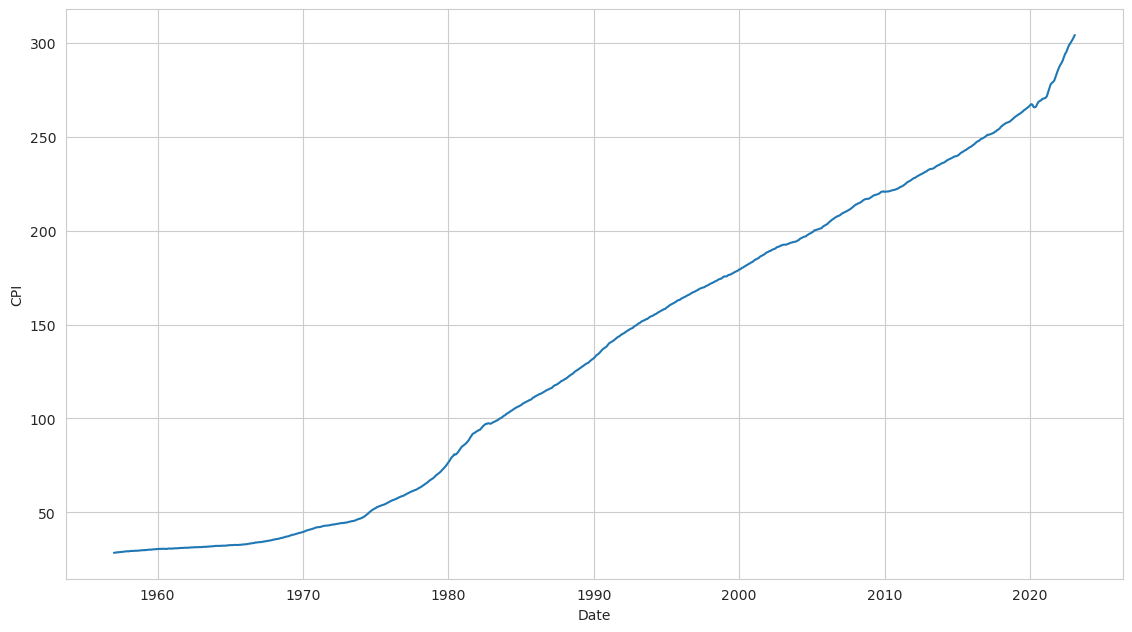

In [25]:
# Plot the time series
# plt.plot(data.index, data['CPI'])
fig, ax = plt.subplots(figsize=(16/1.4, 9/1.4))
sns.lineplot(data=data, x=data.index, y="CPI", ax = ax)
plt.xlabel("Date")

# Display the plot
plt.tight_layout()
fig.savefig("../out/q1_cpi_vs_time.png", dpi = 300)
plt.show()


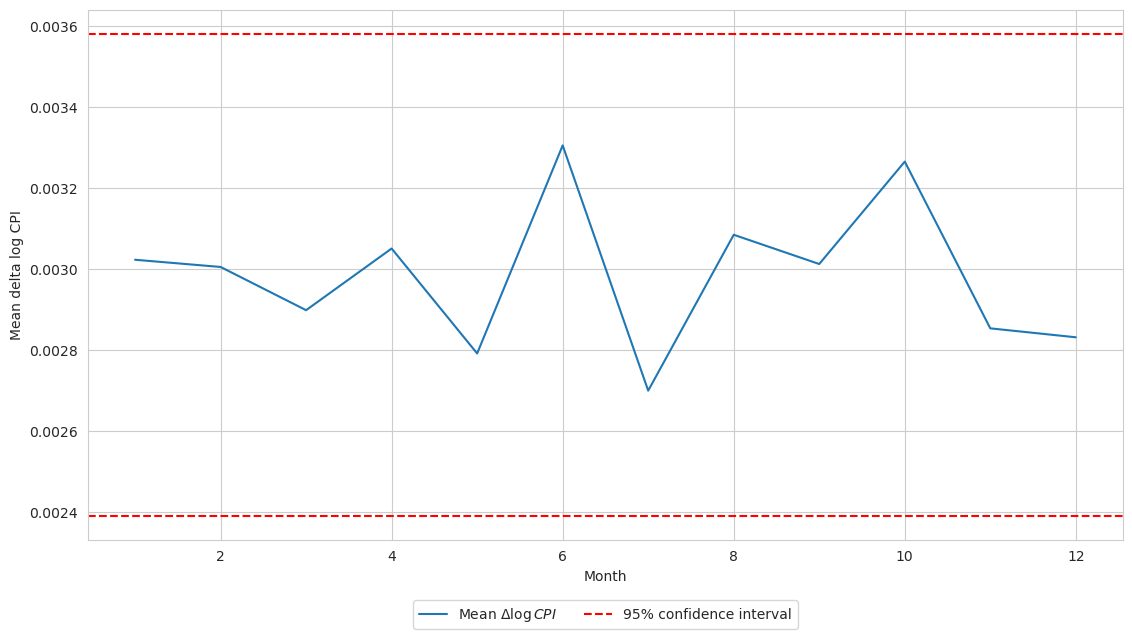

In [26]:
fig, ax = plt.subplots(figsize=(16/1.4, 9/1.4))
delta_df = data.copy()
delta_df["delta_log_CPI"] = np.log(delta_df["CPI"]).diff()
delta_df["month"] = delta_df.index.month
delta_df.dropna(inplace = True)
delta_df.groupby("month")["delta_log_CPI"].mean().plot()
# we add 95% confidence interval above and below
# so we take the stdev of the entire sample, divide by sqrt(n / 12) and multiply by 1.96
# to get the 95% confidence interval
plt.axhline(y = delta_df["delta_log_CPI"].mean() + 1.96 * delta_df["delta_log_CPI"].std() / np.sqrt(len(delta_df) / 12), color = "red", linestyle = "--")
plt.axhline(y = delta_df["delta_log_CPI"].mean() - 1.96 * delta_df["delta_log_CPI"].std() / np.sqrt(len(delta_df) / 12), color = "red", linestyle = "--")
plt.xlabel("Month")
plt.ylabel("Mean delta log CPI")
# we add a legend to show the 95% confidence interval
# plt.legend(["Mean delta log CPI", "95% confidence interval"])
# we move the legend outside of the plot, right below
plt.legend(["Mean $\Delta \log CPI$", "95% confidence interval"], bbox_to_anchor=(0.5, -0.18), loc='lower center', ncol=2)
fig.tight_layout()
fig.savefig("../out/q1_mean_delta_log_cpi_vs_month.png", dpi = 300)
plt.show()


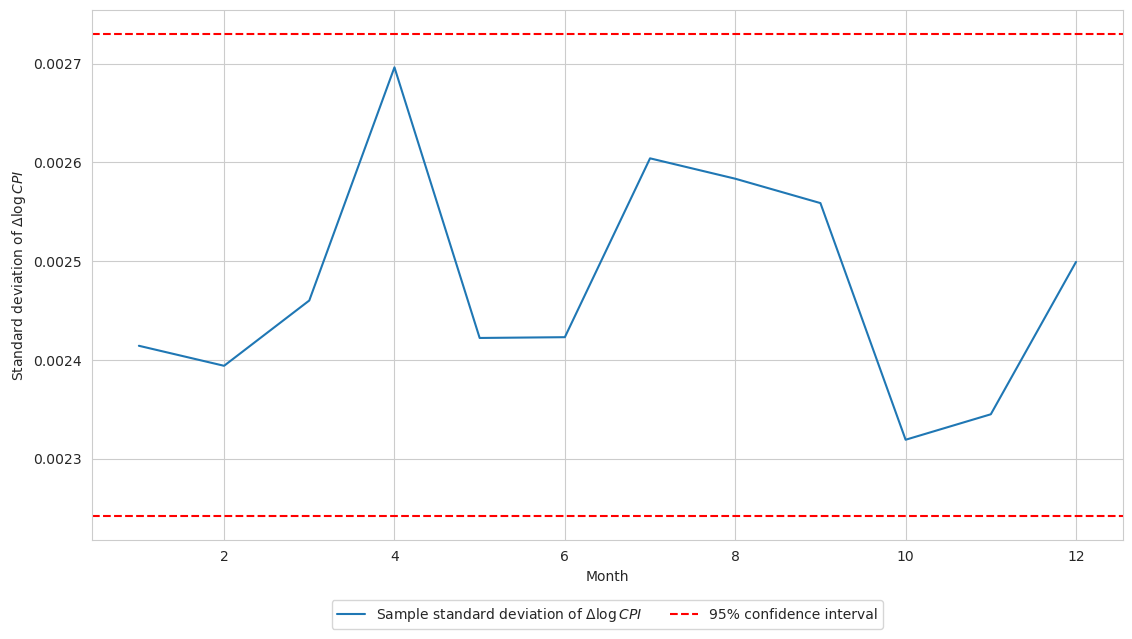

In [27]:
from scipy.stats import chi2

fig, ax = plt.subplots(figsize=(16/1.4, 9/1.4))
delta_df.groupby("month")["delta_log_CPI"].std().plot()
# we add 95% confidence interval above and below
# so we use that Q = (n-1) S^2 / sigma^2 ~ chi^2(n-1)
# and we know that 95% of the chi^2 distribution is between 0.025 and 0.975
n = len(delta_df)
plt.axhline(y = delta_df["delta_log_CPI"].std() * (n-1) / chi2.ppf(0.975, n-1), color = "red", linestyle = "--")
plt.axhline(y = delta_df["delta_log_CPI"].std() * (n-1) / chi2.ppf(0.025, n-1), color = "red", linestyle = "--")
plt.xlabel("Month")
plt.ylabel("Standard deviation of $\Delta \log CPI$")

# we move the legend outside of the plot, right below
plt.legend(["Sample standard deviation of $\Delta \log CPI$", "95% confidence interval"], bbox_to_anchor=(0.5, -0.18), loc='lower center', ncol=2)
fig.tight_layout()
fig.savefig("../out/q1_stddev_delta_log_cpi_vs_month.png", dpi = 300)
plt.show()


In [28]:
# we test for seasonality by doing OLS with dummies for the months
# except for month 1
sm.OLS(delta_df["delta_log_CPI"], sm.add_constant(pd.get_dummies(delta_df["month"], drop_first = True))).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_log_CPI   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.3557
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.972
Time:                        08:25:28   Log-Likelihood:                 3638.8
No. Observations:                 793   AIC:                            -7254.
Df Residuals:                     781   BIC:                            -7197.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.000      9.907      0.000       0.002       0.004
2          -1.779e-05      0.000     -0.041      0.967      -0.001       0.001
3             -0.0001      0.000     -0.288      0.773      -0.001       0.001
4           2.771e-05      0.000      0.064      0.949      -0.001       0.001
5             -0.0002      0.000     -0.536      0.592      -0.001       0.001
6              0.0003      0.000      0.654      0.514      -0.001       0.001
7             -0.0003      0.000     -0.748      0.455      -0.001       0.001
8           6.162e-05      0.000      0.143      0.886      -0.001       0.001
9          -1.052e-05      0.000     -0.024      0.981      -0.001       0.001
10             0.0002      0.000      0.561      0.575      -0.001       0.001
11            -0.0002      0.000     -0.392      0.695      -0.001       0.001
12            -0.0002      0.000     -0.443      0.658      -0.001       0.001
==============================================================================
Omnibus:                      200.325   Durbin-Watson:                   0.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              510.952
Skew:                           1.300   Prob(JB):                    1.12e-111
Kurtosis:                       5.951   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Key features:

- Trend

There is a very clear upwards trend in the data, which seems to be quadratically up until 1980 and linearly after that.

- Seasonality

We do not observe clear seasonality from the plot above. However, this plot shows a large timeframe which makes it difficult to see monthly patterns. To check for seasonality, we could do an OLS with dummy variables for the months, and then do a joint F-test to test the significance of the corresponding coefficients.

- Aberrant observations

From the plot above, we do not see significant outliers.

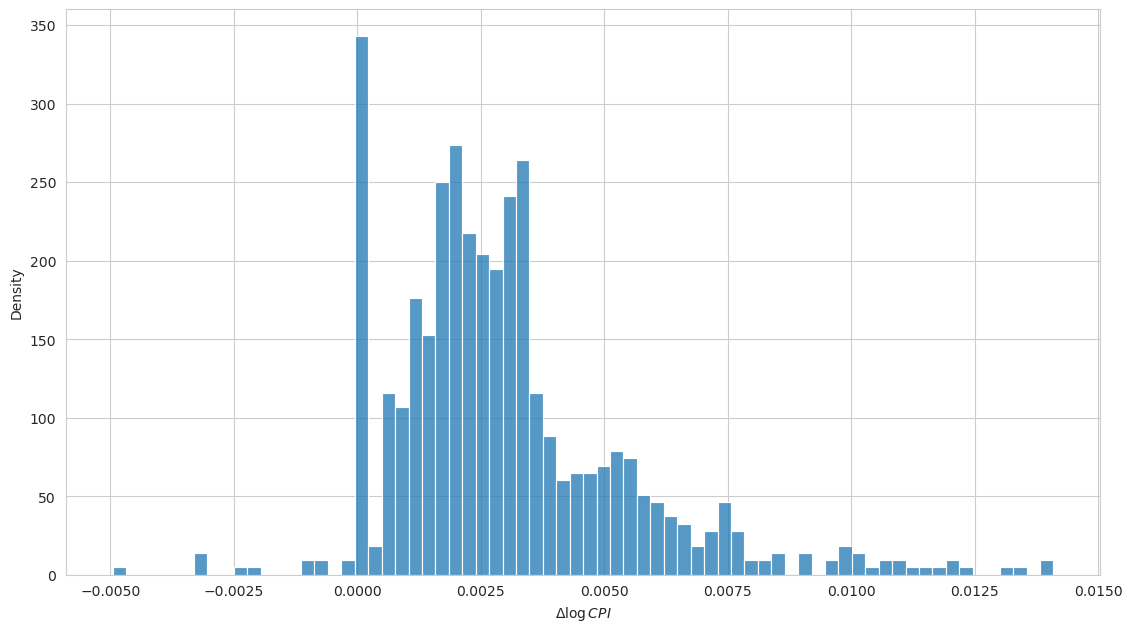

In [29]:
fig, ax = plt.subplots(figsize=(16/1.4, 9/1.4))
sns.histplot(delta_df["delta_log_CPI"], ax = ax, bins = 70, stat = "density")
plt.xlabel("$\Delta \log CPI$")
fig.tight_layout()
fig.savefig("../out/q1_hist_delta_log_cpi.png", dpi = 300)

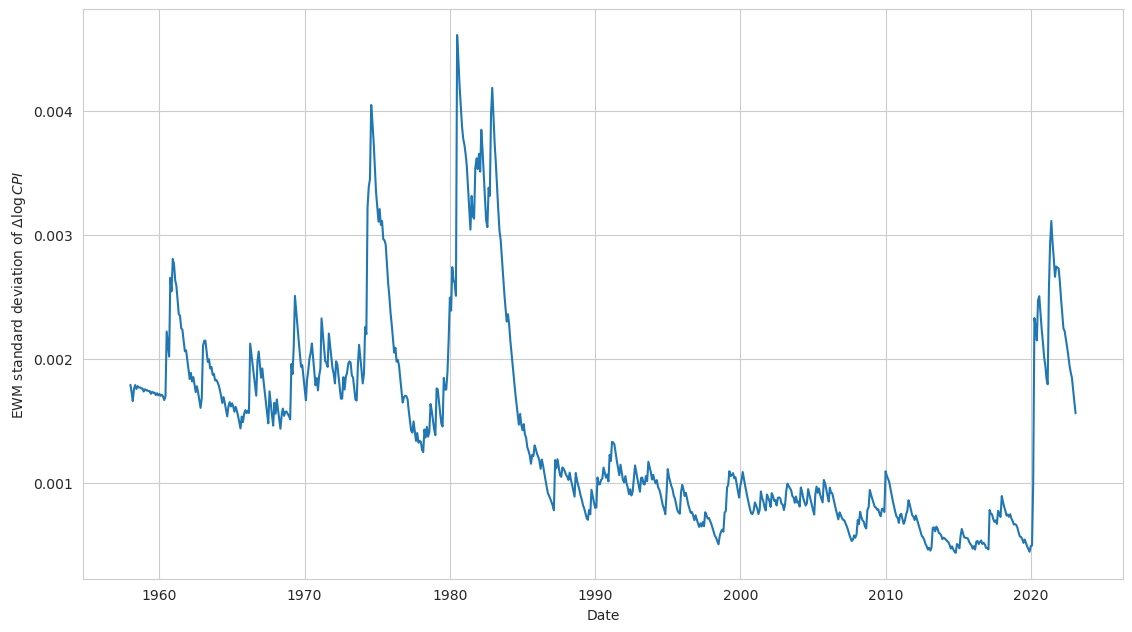

In [30]:
# for time varying volatility, we plot the squared residuals
fig, ax = plt.subplots(figsize=(16/1.4, 9/1.4))
# sns.lineplot(data = (delta_df["delta_log_CPI"] - delta_df["delta_log_CPI"].mean())**2, ax = ax)
sns.lineplot(data = delta_df["delta_log_CPI"].ewm(halflife = 6, min_periods = 12).std(), ax = ax)
plt.xlabel("Date")
plt.ylabel("EWM standard deviation of $\Delta \log CPI$")
fig.tight_layout()
fig.savefig("../out/q1_ewm_std.png", dpi = 300)


### 2.
#### (1 point)
Check whether a linear or quadratic time trend is present in the data by estimating

$y_t = \alpha + \beta t + u_t, \forall t = 1, . . . , T$

$y_t = \alpha + \beta t^2 + u_t, \forall t = 1, . . . , T$

with ordinary least squares and discussing your results.

In [31]:
# Define the time variable t
data["t"] = range(1, len(data) + 1)
data["t^2"] = data["t"] ** 2


In [32]:
# Model 1: Linear trend
model1 = sm.OLS(data["CPI"], sm.add_constant(data["t"])).fit()

# Print the summary of the model
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 4.173e+04
Date:                Fri, 12 May 2023   Prob (F-statistic):               0.00
Time:                        08:25:31   Log-Likelihood:                -3047.0
No. Observations:                 794   AIC:                             6098.
Df Residuals:                     792   BIC:                             6107.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.8960      0.799     -8.632      0.0

In [33]:
# Model 2: Quadratic trend
model2 = sm.OLS(data["CPI"], sm.add_constant(data["t^2"])).fit()

# Print the summary of the model
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                 1.943e+04
Date:                Fri, 12 May 2023   Prob (F-statistic):               0.00
Time:                        08:25:31   Log-Likelihood:                -3342.2
No. Observations:                 794   AIC:                             6688.
Df Residuals:                     792   BIC:                             6698.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.2332      0.868     50.934      0.0

In [34]:
# Model 2: Quadratic trend
model2 = sm.OLS(data["CPI"], sm.add_constant(data[["t", "t^2"]])).fit()

# Print the summary of the model
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 3.376e+04
Date:                Fri, 12 May 2023   Prob (F-statistic):               0.00
Time:                        08:25:32   Log-Likelihood:                -2858.4
No. Observations:                 794   AIC:                             5723.
Df Residuals:                     791   BIC:                             5737.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6056      0.947      9.087      0.0

### 3.
#### (2 points) 
Fit an AR(1) model with a linear trend to the data. Discuss what conclusions you can draw
from the estimated coefficients.

In [35]:
df_ols

NameError: name 'df_ols' is not defined

In [36]:
# Fit AR(1) with linear trend
# We use OLS to fit the model, and drop the first observation.
df_ols = pd.concat(
    [data["CPI"], data["t"], data["CPI"].shift(1).rename("CPI_lag_1")], axis=1
).dropna()

model = sm.OLS(df_ols["CPI"], sm.add_constant(df_ols[["t", "CPI_lag_1"]])).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.775e+07
Date:                Fri, 12 May 2023   Prob (F-statistic):               0.00
Time:                        08:25:34   Log-Likelihood:                -75.347
No. Observations:                 793   AIC:                             156.7
Df Residuals:                     790   BIC:                             170.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0887      0.020      4.447      0.0

In [37]:
# we get the standard errors
model.bse
# we get the coeffs
# model.params

const        0.019935
t            0.000303
CPI_lag_1    0.000846
dtype: float64

In [38]:
# Fit AR(1) with linear trend
ARIMA(data["CPI"], order=(1, 0, 0), trend = 'ct').fit().summary()

/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CPI   No. Observations:                  794
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -178.526
Date:                Fri, 12 May 2023   AIC                            365.051
Time:                        08:25:34   BIC                            383.760
Sample:                    01-01-1957   HQIC                           372.241
                         - 02-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.8384    118.111      0.100      0.920    -219.654     243.331
x1             0.3487      0.013     27.324      0.000       0.324       0.374
ar.L1          0.9999      0.001   1143.416      0.000       0.998       1.002
sigma2         0.0908      0.003     35.940      0.000       0.086       0.096
===================================================================================
Ljung-Box (L1) (Q):                 420.13   Jarque-Bera (JB):              3013.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.69   Skew:                             1.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 4.
#### (2 points) 
Fit a random walk

$y_t = y_{t−1} + u_t, \forall t = 1, . . . , T$

and a random walk with linear trend

$y_t = y_{t−1} + \beta t + u_t, \forall t = 1, . . . , T$

to the data. Which of the two models fits the data better based on the Akaike Information Criterion
(AIC)? What is the difference between the random walk with linear trend and the AR(1) model with
linear trend estimated before?

In [39]:
# Random walk
# TODO: replace w OLS
# model1 = SimpleExpSmoothing(CPI_series).fit()
df_ols = data.assign(
    delta_CPI=lambda df: df["CPI"].diff(),
    zeros=lambda df: np.zeros(len(df)),
    const=lambda df: np.ones(len(df)),
)[["delta_CPI", "zeros", "const", "t"]].dropna()

# model1 = sm.OLS(df_ols["delta_CPI"], df_ols["zeros"]).fit()
model1 = sm.OLS(df_ols["delta_CPI"], df_ols["const"]).fit()

# Print the model summary
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_CPI   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 12 May 2023   Prob (F-statistic):                nan
Time:                        08:25:36   Log-Likelihood:                -174.22
No. Observations:                 793   AIC:                             350.4
Df Residuals:                     792   BIC:                             355.1
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3475      0.011     32.445      0.0

In [40]:
model1 = ARIMA(data["CPI"], order = (0, 1, 0)).fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                  794
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -509.457
Date:                Fri, 12 May 2023   AIC                           1020.914
Time:                        08:25:37   BIC                           1025.589
Sample:                    01-01-1957   HQIC                          1022.711
                         - 02-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2116      0.007     29.954      0.000       0.198       0.225
Ljung-Box (L1) (Q):                 420.94   Jarque-Bera (JB):              2992.81
Prob(Q):                              0.00   Pr

/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='DATE'>

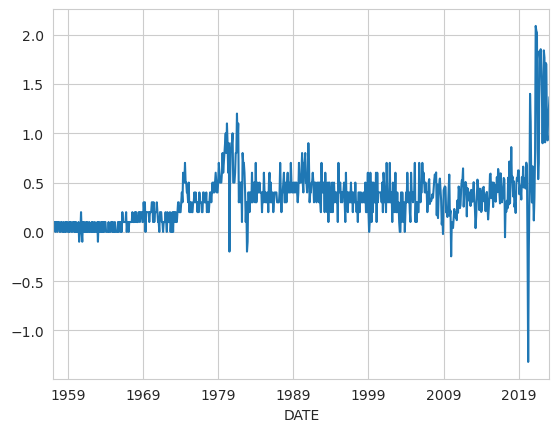

In [41]:
df_ols["delta_CPI"].plot()

In [42]:
# Random walk with linear trend
model2 = sm.OLS(df_ols["delta_CPI"], sm.add_constant(df_ols["t"])).fit()

# Print the model summary
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:              delta_CPI   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     214.0
Date:                Fri, 12 May 2023   Prob (F-statistic):           4.50e-43
Time:                        08:25:38   Log-Likelihood:                -79.265
No. Observations:                 793   AIC:                             162.5
Df Residuals:                     791   BIC:                             171.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1057      0.019      5.541      0.0

In [43]:
data["CPI"].diff().mean()

0.34750315258511977

In [44]:
model2 = ARIMA(data["CPI"], order = (0, 1, 0), exog = data["t"]).fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                  794
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -174.218
Date:                Fri, 12 May 2023   AIC                            352.437
Time:                        08:25:38   BIC                            361.788
Sample:                    01-01-1957   HQIC                           356.031
                         - 02-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
t              0.3475      0.013     26.936      0.000       0.322       0.373
sigma2         0.0909      0.002     38.362      0.000       0.086       0.096
Ljung-Box (L1) (Q):                 420.94   Jarque-

/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Warning: R^2 is uncentered!!! Cannot compare. https://stats.stackexchange.com/questions/26176/removal-of-statistically-significant-intercept-term-increases-r2-in-linear-mo

### 5.
#### (2 points) 
Is the time series normally distributed? Perform a Jarque-Bera test. Clearly state the null
hypothesis of the test, the value of the test statistic, p-value, whether you reject or not and what
conclusions you can draw.

$H_0: \text{CPI is normally distributed}$

$H_A: \text{CPI is not normally distributed}$

In [45]:
# Perform Jarque-Bera test
jb_test = jarque_bera(df_ols["delta_CPI"])

# Print the test statistic and p-value
print("Jarque-Bera test statistic:", jb_test[0])
print("Jarque-Bera p-value:", jb_test[1])


Jarque-Bera test statistic: 2992.8080320072168
Jarque-Bera p-value: 0.0


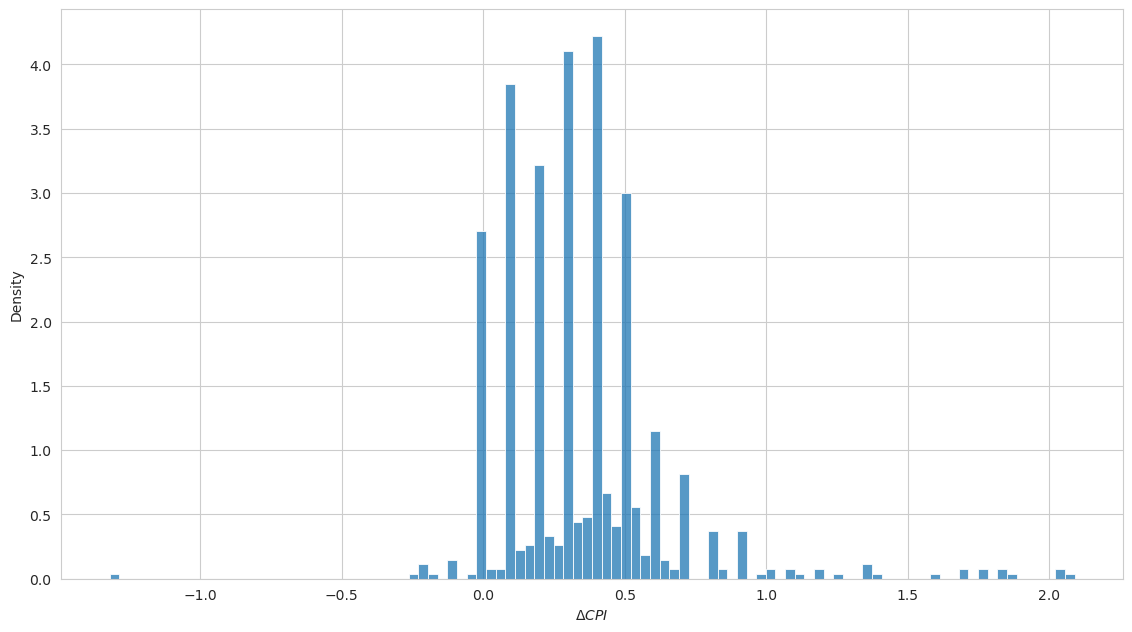

In [46]:
fig, ax = plt.subplots(figsize=(16/1.4, 9/1.4))
sns.histplot(df_ols["delta_CPI"], ax = ax, bins = 100, stat = "density")
plt.xlabel("$\Delta CPI$")
fig.tight_layout()
fig.savefig("../out/q5_hist_delta_cpi.png", dpi = 300)

In [47]:
df_ols

,delta_CPI,zeros,const,t
DATE,,,,
1957-02-01,0.100,0.0,1.0,2
1957-03-01,0.100,0.0,1.0,3
1957-04-01,0.100,0.0,1.0,4
1957-05-01,0.000,0.0,1.0,5
1957-06-01,0.100,0.0,1.0,6
...,...,...,...,...
2022-10-01,0.994,0.0,1.0,790
2022-11-01,0.928,0.0,1.0,791
2022-12-01,1.199,0.0,1.0,792


In [48]:
df_ols.query("DATE >= '2007-01-01'").head(10)

,delta_CPI,zeros,const,t
DATE,,,,
2007-01-01,0.500,0.0,1.0,601
2007-02-01,0.535,0.0,1.0,602
2007-03-01,0.283,0.0,1.0,603
2007-04-01,0.329,0.0,1.0,604
2007-05-01,0.311,0.0,1.0,605
2007-06-01,0.334,0.0,1.0,606
2007-07-01,0.381,0.0,1.0,607
2007-08-01,0.346,0.0,1.0,608
2007-09-01,0.435,0.0,1.0,609


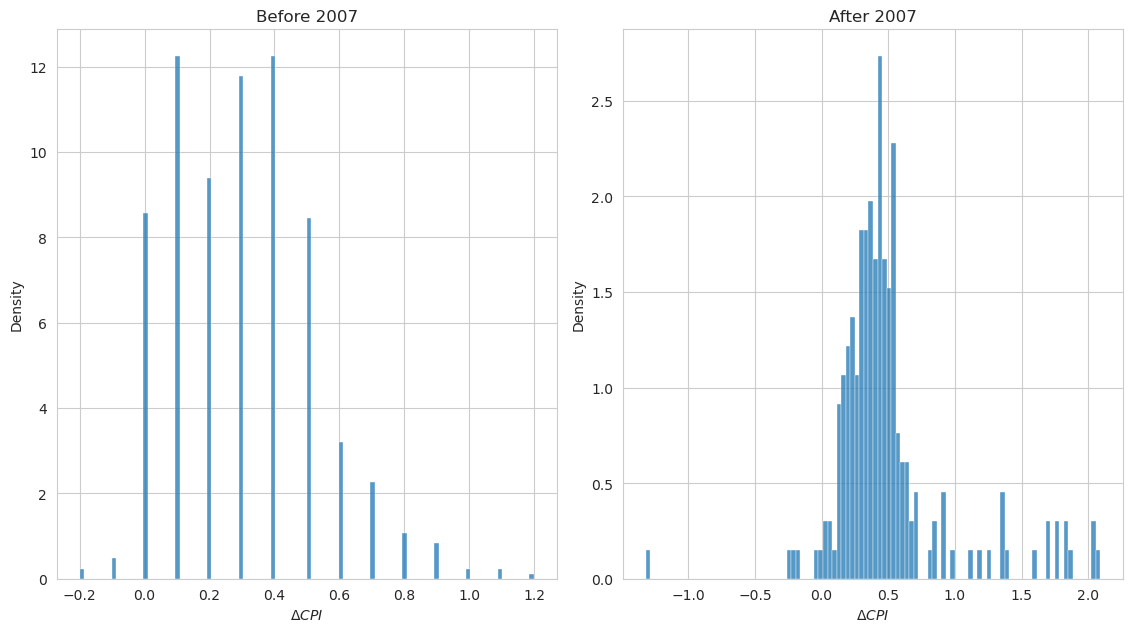

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(16/1.4, 9/1.4))
sns.histplot(df_ols.query("DATE <= '2007-01-01'")["delta_CPI"], ax = ax[0], bins = 100, stat = "density")
sns.histplot(df_ols.query("DATE > '2007-01-01'")["delta_CPI"], ax = ax[1], bins = 100, stat = "density")
ax[0].set_xlabel("$\Delta CPI$")
ax[1].set_xlabel("$\Delta CPI$")
ax[0].set_title("Before 2007")
ax[1].set_title("After 2007")
fig.tight_layout()
fig.savefig("../out/q5_hist_delta_cpi_per_timeframe.png", dpi = 300)

We reject $H_0$ at 5% signifiance. We conclude that CPI is not normally distributed.

### 6.
#### (1 point) 
Create a time series of monthly growth rates of CPI by taking the first differences of the log
series and multiplying by 100 (to put the growth rates in terms of percentage points). Are these growth
rates normally distributed?

In [50]:
# Create a new dataframe with log CPI
df = data["CPI"].to_frame()
df["log_CPI"] = np.log(df["CPI"])

# Calculate monthly growth rates
df["CPI_growth"] = df["log_CPI"].diff() * 100

df.dropna(inplace=True)
# Print the first few rows of the dataframe
print(df.head())


             CPI   log_CPI  CPI_growth
DATE                                  
1957-02-01  28.6  3.353407    0.350263
1957-03-01  28.7  3.356897    0.349040
1957-04-01  28.8  3.360375    0.347826
1957-05-01  28.8  3.360375    0.000000
1957-06-01  28.9  3.363842    0.346621


In [51]:
# Perform Jarque-Bera test
jb_test = jarque_bera(df["CPI_growth"])

# Print the test statistic and p-value
print("Jarque-Bera test statistic:", jb_test[0])
print("Jarque-Bera p-value:", jb_test[1])


Jarque-Bera test statistic: 494.46822798290344
Jarque-Bera p-value: 0.0


Text(0.5, 0, '$\\Delta \\log(CPI)$')

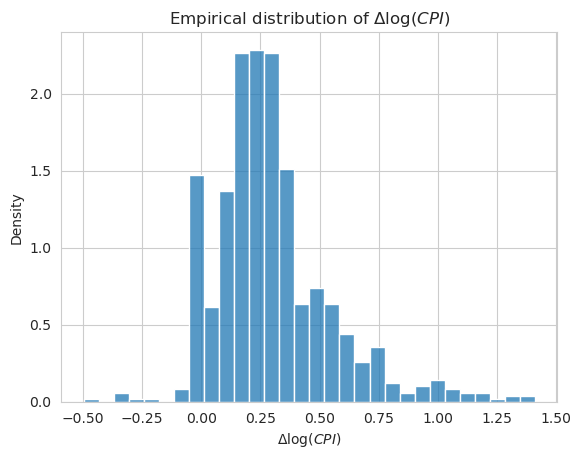

In [52]:
sns.histplot(df["CPI_growth"], bins=30, stat="density")
plt.title("Empirical distribution of $\Delta \log(CPI)$")
plt.xlabel("$\Delta \log(CPI)$")


Again, we conclude growth rates are not normally distributed.

### 7.
#### (3 points) 
Compute the first 48 empirical autocorrelations and partial autocorrelations for the monthly
growth rates of CPI. What conclusions can you draw based on the ACF and PACF regarding selecting
an MA, AR or ARMA model?

/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


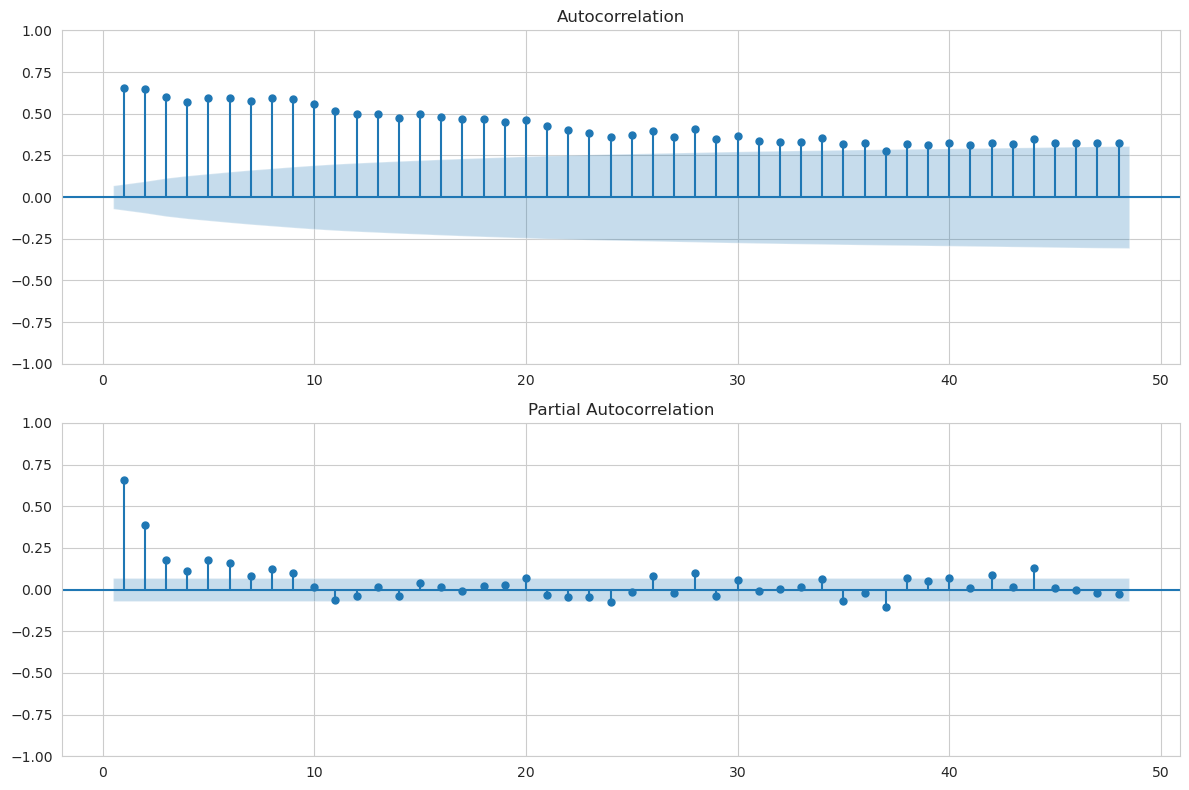

In [53]:
# Compute and plot the autocorrelations and partial autocorrelations
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
fig1 = plot_acf(df["CPI_growth"], lags=48, ax=ax[0], zero=False)
fig2 = plot_pacf(df["CPI_growth"], lags=48, ax=ax[1], zero=False)

# Show the plots
fig.tight_layout()
fig.savefig("../out/q7_acf_pacf.png", dpi = 300)

plt.show()


/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


-620.8865031992519


/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


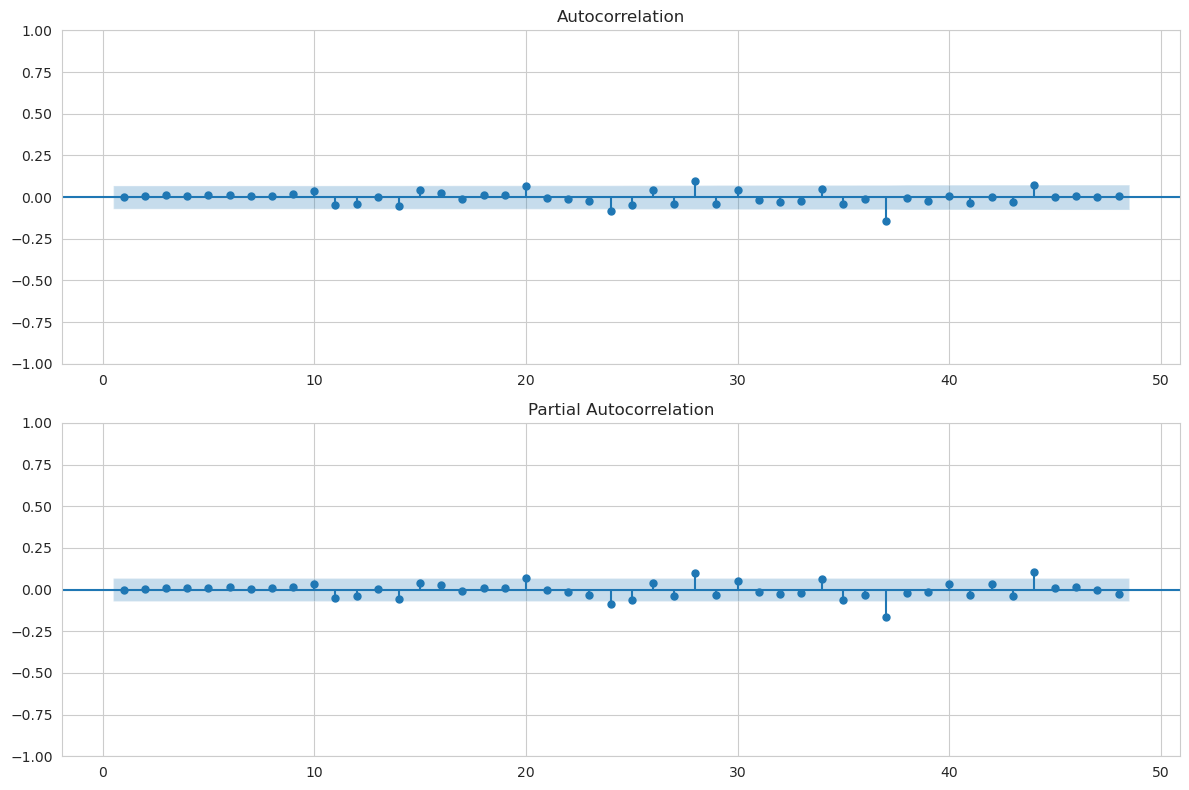

In [56]:
# we do AR(2) and visualise the ACF and PACF of the residuals.
# Fit the model
model = ARIMA(df["CPI_growth"], order=(9, 0, 0)).fit()
print(model.aic)
resid = model.resid
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

fig1 = plot_acf(resid, lags=48, ax=ax[0], zero=False)
fig2 = plot_pacf(resid, lags=48, ax=ax[1], zero=False)

fig.tight_layout()
fig.savefig("../out/q7_resid_ar9_acf_pacf.png", dpi = 300)

plt.show()

plt.show()


AR(2) seems ok.

### 8.
#### (2 points) 
Estimate AR(p) and MA(q) models for p = 1, . . . , 24 and q = 1, . . . , 24 using the calculated
monthly growth rates of CPI. Include a constant in the models. Select which model you would chose
based on the values of the Akaike Information Criterion (AIC).


In [90]:
from joblib import Parallel, delayed

MAX_K = 24


def work_k(k, verbose=False):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # we include a constant
        ar_model = ARIMA(df["CPI_growth"], order=(k, 0, 0), trend="c").fit()
        ma_model = ARIMA(df["CPI_growth"], order=(0, 0, k), trend="c").fit()
        if verbose:
            print("AR:")
            print(ar_model.summary())
            print("MA:")
            print(ma_model.summary())
        return {
            "k": k,
            "AR_AIC": ar_model.aic,
            "MA_AIC": ma_model.aic,
        }


work_k(9, verbose=True)


AR:
                               SARIMAX Results                                
Dep. Variable:             CPI_growth   No. Observations:                  793
Model:                 ARIMA(9, 0, 0)   Log Likelihood                 321.443
Date:                Thu, 11 May 2023   AIC                           -620.887
Time:                        09:48:21   BIC                           -569.452
Sample:                    02-01-1957   HQIC                          -601.120
                         - 02-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3044      0.074      4.102      0.000       0.159       0.450
ar.L1          0.2367      0.029      8.178      0.000       0.180       0.293
ar.L2          0.2129      0.029      7.407     

{'k': 9, 'AR_AIC': -620.8865031992519, 'MA_AIC': -526.8130207242157}

In [91]:
arma_df = Parallel(n_jobs=12)(delayed(work_k)(k) for k in range(1, MAX_K + 1))
arma_df = pd.DataFrame(arma_df).set_index("k")


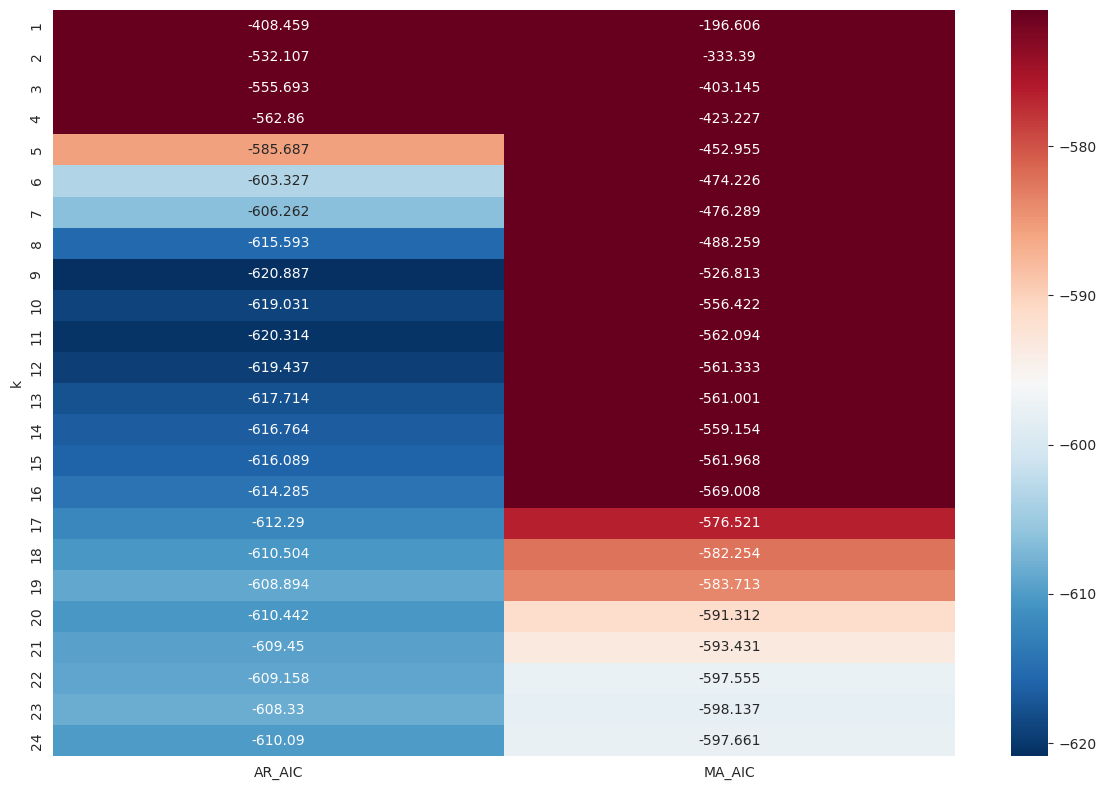

Best AR model: AR(9), AIC = -620.8865031992519
Best MA model: MA(23), AIC = -598.1365144767663


In [92]:
# sns.heatmap(out.set_index("k"), annot = True)
# we flip around the color map
minval = arma_df.min().min()
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(arma_df, annot=True, cmap="RdBu_r", vmin=minval, vmax=minval + 50, fmt="g", ax = ax)
fig.tight_layout()
fig.savefig("../out/q8_arma_heatmap.png", dpi = 300)
plt.show()
print(
    f"Best AR model: AR({arma_df['AR_AIC'].idxmin()}), AIC = {arma_df['AR_AIC'].min()}"
)
print(
    f"Best MA model: MA({arma_df['MA_AIC'].idxmin()}), AIC = {arma_df['MA_AIC'].min()}"
)


### 9.
#### (1 point) 
Fit an ARMA(p, q) model to the growth rates of CPI. Chose the best lag length based on AIC
with maximum lag length of 24. Include a constant in the model. Compare your findings to the before
selected AR and MA models.

In [93]:
def work_arma(p, q, verbose=False):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # we include a constant
        arma_model = ARIMA(df["CPI_growth"], order=(p, 0, q), trend="c").fit()
        if verbose:
            print("ARMA:")
            print(arma_model.summary())
        return {
            "p": p,
            "q": q,
            "ARMA_AIC": arma_model.aic,
        }


work_arma(3, 3, verbose=True)


ARMA:
                               SARIMAX Results                                
Dep. Variable:             CPI_growth   No. Observations:                  793
Model:                 ARIMA(3, 0, 3)   Log Likelihood                 316.411
Date:                Thu, 11 May 2023   AIC                           -616.822
Time:                        09:48:33   BIC                           -579.416
Sample:                    02-01-1957   HQIC                          -602.446
                         - 02-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3034      0.080      3.799      0.000       0.147       0.460
ar.L1          0.6996      0.081      8.591      0.000       0.540       0.859
ar.L2         -0.4842      0.105     -4.595   

{'p': 3, 'q': 3, 'ARMA_AIC': -616.8222900417913}

In [105]:
arma_df = Parallel(n_jobs=-1, verbose=2)(
    delayed(work_arma)(p, q) for p in range(0, MAX_K + 1) for q in range(0, MAX_K + 1)
)
arma_df = pd.DataFrame(arma_df)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed:  3.5min finished


In [109]:
arma_df

,p,q,ARMA_AIC
0,0,0,34.209981
1,0,1,-196.606493
2,0,2,-333.390216
3,0,3,-403.145383
4,0,4,-423.227075
...,...,...,...
620,24,20,-603.966536
621,24,21,-604.570079
622,24,22,-631.125475
623,24,23,-621.430385


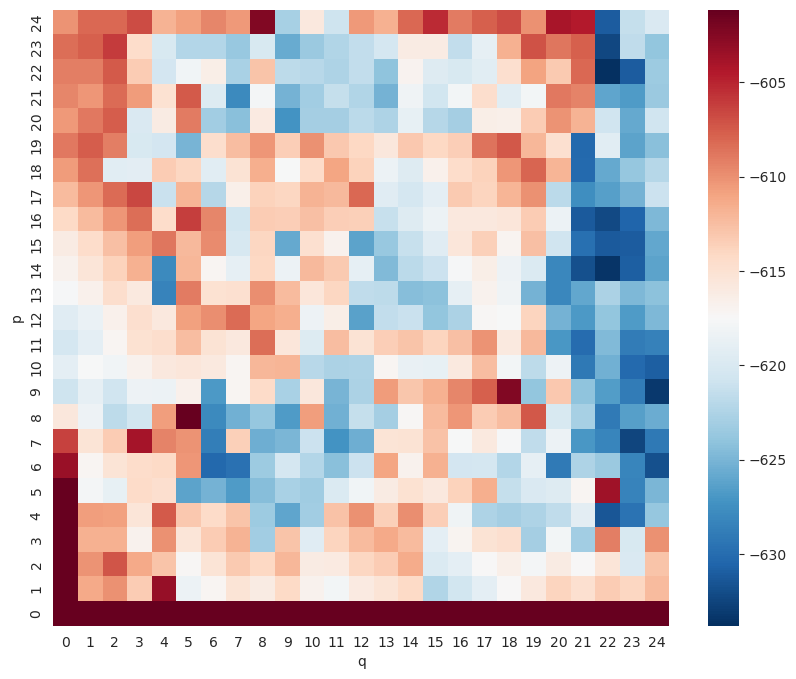

In [110]:
fig, ax = plt.subplots(figsize=(10, 8))
arma_df_pivoted = arma_df.pivot(index="p", columns="q", values="ARMA_AIC")
mn = arma_df_pivoted.min().min()
mx = arma_df.query("p >= 1 and q >= 1")["ARMA_AIC"].max()
print()
sns.heatmap(arma_df_pivoted, annot=False, fmt="g", cmap="RdBu_r", ax = ax, square = True, vmin = mn, vmax = mx)
plt.gca().invert_yaxis()
fig.savefig("../out/q9_arma_heatmap.png", dpi = 300)
# plt.title("AIC of ARMA(p, q)")
plt.show()


In [ ]:
arma_df.sort_values(by="ARMA_AIC").head(5)


,p,q,ARMA_AIC
525,22,22,-633.810708
333,14,22,-633.479947
215,9,24,-633.287498
166,7,23,-632.508624
549,23,22,-632.285970


The best model is ARMA(22, 22) with an AIC of $\approx -633.81$.

### 10.
#### (3 points) 
Estimate an AR(9) model (including a constant). Calculate fitted values based on your
estimated coefficients of the AR(9) process and compare these to the true data by plotting them in one
graph. What do you conclude about the fit of your model?

With CPI

In [111]:
fitted_ar

NameError: name 'fitted_ar' is not defined

/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


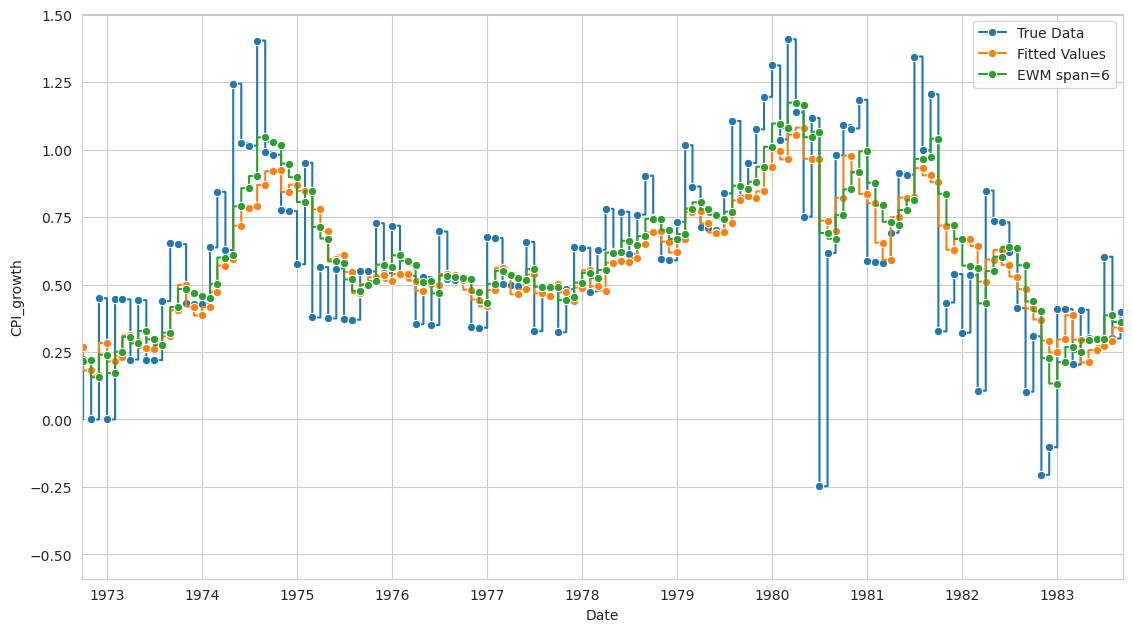

In [129]:
# Fit AR(9) model
model_ar = ARIMA(df["CPI_growth"], order=(9, 0, 0), trend = "c").fit()

# Calculate fitted values
fitted_ar = model_ar.predict()

# Plot true data and fitted values
fig, ax = plt.subplots(figsize = (16/1.4, 9/1.4))
sns.lineplot(df["CPI_growth"], label="True Data", drawstyle="steps-post", marker = "o", ax = ax)
sns.lineplot(fitted_ar, label="Fitted Values", drawstyle="steps-pre", marker = "o", ax = ax)
sns.lineplot(df["CPI_growth"].ewm(span = 6).mean().shift(1), label="EWM span=6", drawstyle="steps-pre", marker = "o", ax = ax)
plt.xlabel("Date")
plt.legend()
plt.xlim(1000, 5000)
fig.tight_layout()
fig.savefig("../out/q10_ar9_fit_zoom.png", dpi = 300)
# plt.show()

plt.xlim(1000, 5000)
plt.show()


### 11.
#### (3 points) 
Inspect the properties of the time series residuals of the AR(9) model. Are the residuals
following a White Noise process? Are they autocorrelated? Are they homoskedastic? You can address
these questions by calculating mean and standard deviation, calculating the autocorrelation function
based on the residuals, and plotting the residuals. What conclusions do you draw with respect to the
adequacy of the estimated AR(9) model?

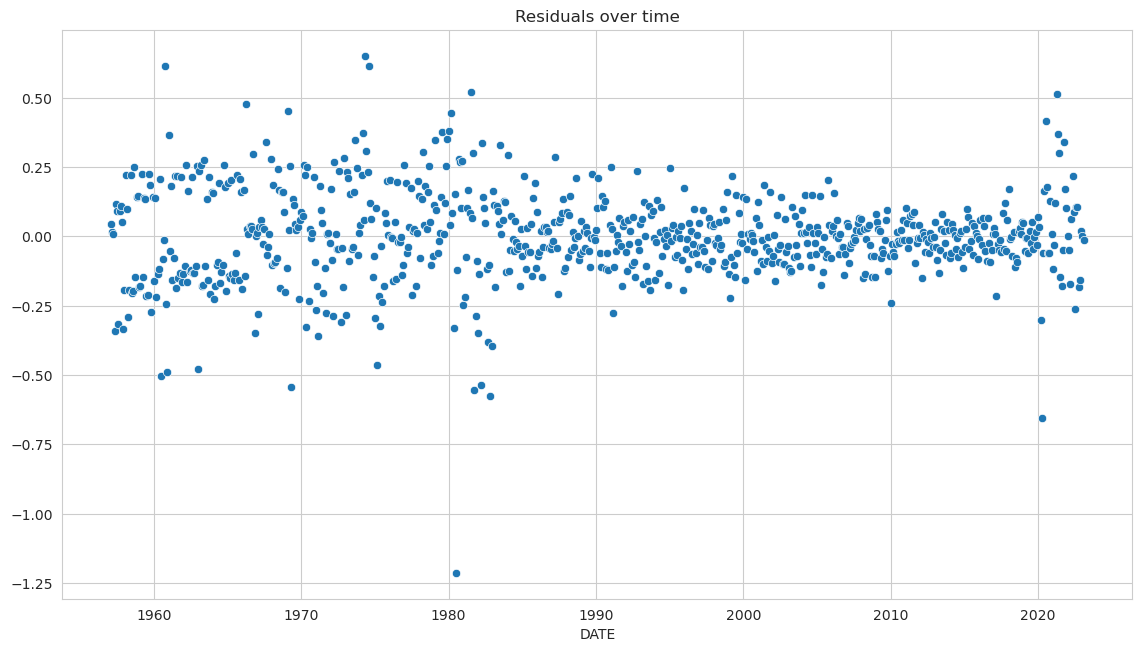

In [137]:
resid = model_ar.resid
fig, ax = plt.subplots(figsize = (16/1.4, 9/1.4))
plt.title("Residuals over time")
fig.tight_layout()
sns.scatterplot(resid, ax = ax)
fig.savefig("../out/q11_ar9_resid.png", dpi = 300)

Jarque_beraResult(statistic=1010.0227500095058, pvalue=0.0)

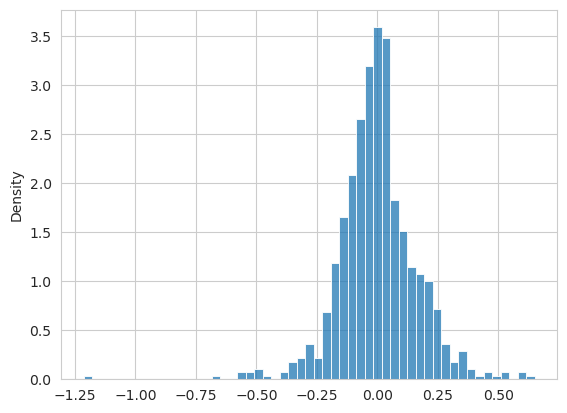

In [151]:
sns.histplot(model_ar.resid, stat = "density")
jarque_bera(model_ar.resid)

In [152]:
# we do a breusch-pagan test
from statsmodels.stats.diagnostic import het_breuschpagan

df_bp = df.copy()
# all 9 lags of CPI_growth
for lag in range(1, 10):
    df_bp[f"CPI_growth_lag_{lag}"] = df_bp["CPI_growth"].shift(lag)

df_bp = df_bp.dropna()

# we do a breusch-pagan test
res = het_breuschpagan(model_ar.resid.loc[df_bp.index], df_bp[["CPI_growth_lag_1", "CPI_growth_lag_2", "CPI_growth_lag_3", "CPI_growth_lag_4", "CPI_growth_lag_5", "CPI_growth_lag_6", "CPI_growth_lag_7", "CPI_growth_lag_8", "CPI_growth_lag_9"]])
print(f"LM: {res[0]}")
print(f"Breusch-Pagan test: p = {res[1]}")


LM: 143.95400524749772
Breusch-Pagan test: p = 3.568112667875017e-27


In [153]:
len(df_bp)

784

We observe there is heteroskedasticity, because residuals had a higher dispersion before 1980. This is not consistent with the residuals following a white noise process.

We also notice a big outlier near 1980.

/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


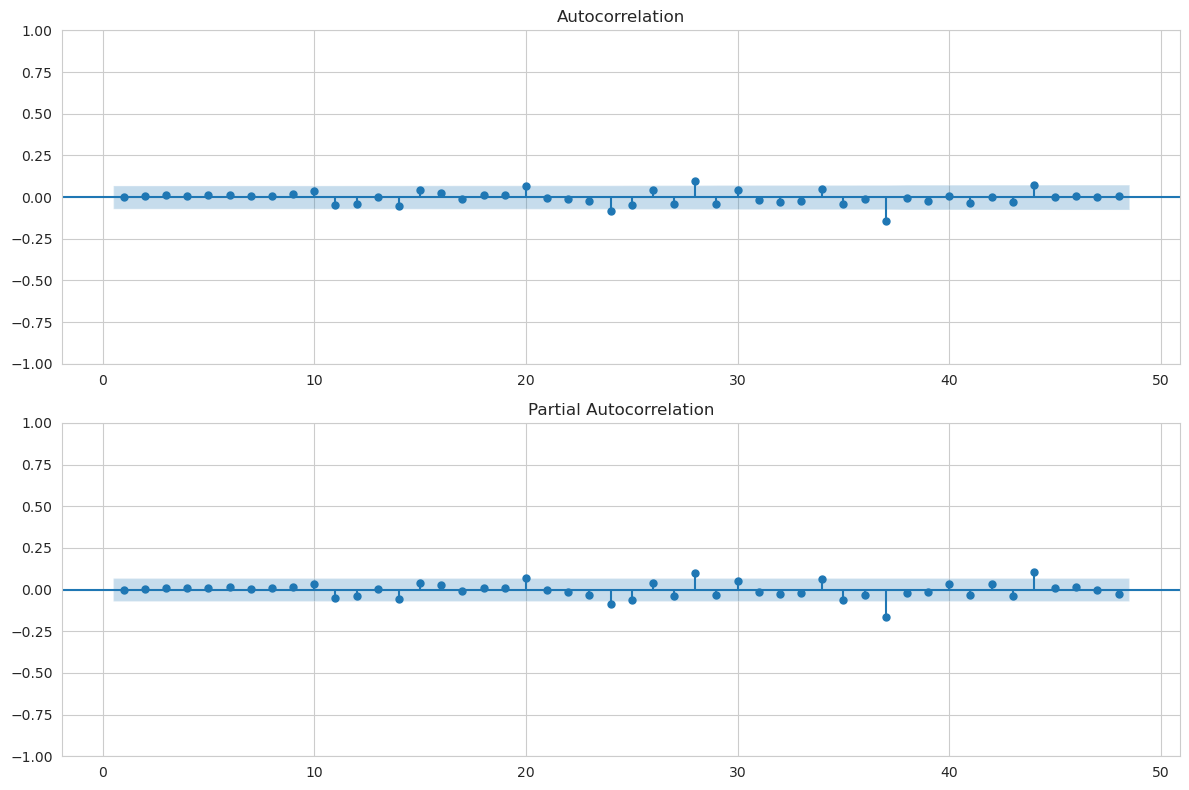

In [154]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(resid, lags=48, ax=ax[0], zero=False)
plot_pacf(resid, lags=48, ax=ax[1], zero=False)
fig.tight_layout()
fig.savefig("../out/q11_ar9_resid_acf_pacf.png", dpi = 300)
plt.show()

<Axes: >

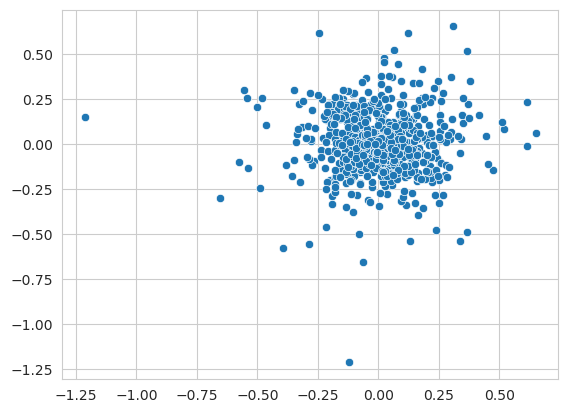

In [155]:
sns.scatterplot(x = resid, y = resid.shift(1))

There is no apparent autocorrelation.

Jarque-Bera test statistic: 1010.0227500095058
Jarque-Bera p-value: 0.0


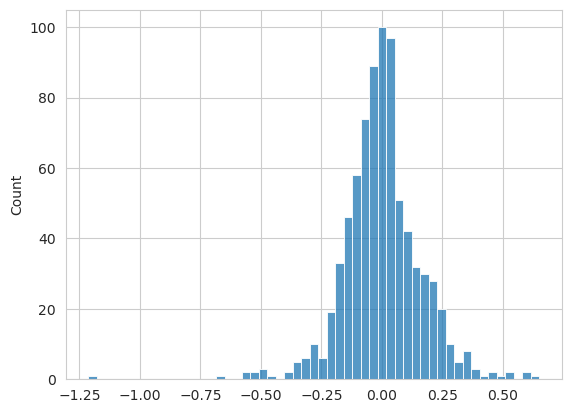

In [156]:
# jarque bera
jb_test = jarque_bera(resid)

sns.histplot(resid)

# Print the test statistic and p-value
print("Jarque-Bera test statistic:", jb_test[0])
print("Jarque-Bera p-value:", jb_test[1])

The AR(9) has fully removed the autocorrelation in the residuals. The residuals are, however, not normally distributed. The Jarque-Bera test rejects the null hypothesis of normality of the residuals.


### 12.
#### (6 points) 
Evaluate the forecast performance of the AR(9) model. Split the sample into an estimation
period and a forecasting period from January 2015 to February 2023. Produce one-step, two-step,
three-step and four-step ahead forecasts for the period January 2015 to February 2023 using a moving
window. Thus, to obtain a one-step ahead forecast for January 2015 use the observations from January
1957 to December 2014, to obtain a one-step ahead forecast for February 2015 use the observations from
February 1957 to January 2015 and so on. Compare you results to forecasts based on an AR(1). Include
a constant in all your AR models. Compare the forecasting accuracy of the AR(9) model based on mean
squared forecast errors for each forecasting horizon relative to forecasts based on an AR(1). What do you
conclude about the prediction accuracy of the AR(9) model?

In [157]:
data

,CPI,t,t^2
DATE,,,
1957-01-01,28.500,1,1
1957-02-01,28.600,2,4
1957-03-01,28.700,3,9
1957-04-01,28.800,4,16
1957-05-01,28.800,5,25
...,...,...,...
2022-10-01,299.333,790,624100
2022-11-01,300.261,791,625681
2022-12-01,301.460,792,627264


In [208]:
def do_forecasts_arma(p, q):
    def work(end_of_train_sample):
        df_train = df.loc[df.index <= end_of_train_sample]
        df_test = df.loc[df.index > end_of_train_sample]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model_ar = ARIMA(df_train["CPI_growth"], order=(p, 0, q), trend = "c").fit()
            fitted_ar = model_ar.predict(df_test.head(4).index[0], df_test.head(4).index[-1])

            mses = (df_test["CPI_growth"] - fitted_ar)[:4] ** 2
            mspes = (df_test["CPI_growth"] - fitted_ar)[:4] ** 2 / df_test["CPI_growth"][:4] ** 2
            maes = np.abs(df_test["CPI_growth"] - fitted_ar)[:4]
        # we evaluate MSE
        return dict({
            **dict((f"MSE_{i}", val) for i, val in enumerate(mses, start = 1)),
            **dict((f"MSPE_{i}", val) for i, val in enumerate(mspes, start = 1)),
            **dict((f"MAE_{i}", val) for i, val in enumerate(maes, start = 1)),
            "end_of_train_sample": end_of_train_sample,
            "pred_1": fitted_ar.get(0),
            "pred_2": fitted_ar.get(1),
            "pred_3": fitted_ar.get(2),
            "pred_4": fitted_ar.get(3)
        })

    ses = Parallel(n_jobs = -1)(delayed(work)(end_of_train_sample) for end_of_train_sample in pd.date_range("2014-12", "2023-01", freq = "M"))
    return pd.DataFrame(ses).set_index("end_of_train_sample").sort_index()

forecast_ses = do_forecasts_arma(9, 0)

In [209]:
forecast_ses

,MSE_1,MSE_2,MSE_3,MSE_4,MSPE_1,MSPE_2,MSPE_3,MSPE_4,MAE_1,MAE_2,MAE_3,MAE_4,pred_1,pred_2,pred_3,pred_4
end_of_train_sample,,,,,,,,,,,,,,,,
2014-12-31,1.814287e-03,0.000421,9.715403e-03,0.009704,2.022932e-01,0.018604,1.652805e-01,0.161435,0.042594,0.020517,0.098567,0.098509,0.137297,0.129905,0.143882,0.146668
2015-01-31,8.377070e-04,0.012203,1.149184e-02,0.000036,3.702280e-02,0.207605,1.911746e-01,0.001815,0.028943,0.110469,0.107200,0.006033,0.121479,0.131980,0.137977,0.135572
2015-02-28,1.097072e-02,0.009824,1.702757e-08,0.000076,1.866362e-01,0.163421,8.491723e-07,0.003148,0.104741,0.099114,0.000130,0.008722,0.137707,0.146063,0.141474,0.146730
2015-03-31,6.142360e-03,0.000846,1.582475e-04,0.001853,1.021824e-01,0.042215,6.548572e-03,0.043351,0.078373,0.029095,0.012580,0.043049,0.166804,0.170700,0.168031,0.163708
2015-04-30,1.994940e-03,0.001187,7.372122e-04,0.005078,9.948850e-02,0.049117,1.724549e-02,0.470983,0.044665,0.034452,0.027152,0.071261,0.186270,0.189903,0.179605,0.175096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,1.180968e-02,0.025172,3.009054e-02,0.002530,3.616428e-02,0.227514,3.140422e-01,0.015930,0.108672,0.158657,0.173466,0.050299,0.462779,0.491281,0.483009,0.448823
2022-09-30,3.407002e-02,0.041150,4.697104e-03,0.004784,3.079390e-01,0.429463,2.957475e-02,0.028299,0.184581,0.202854,0.068535,0.069165,0.517205,0.512397,0.467060,0.480314
2022-10-31,2.530414e-02,0.000369,1.416601e-03,0.001288,2.640885e-01,0.002322,8.380116e-03,0.006333,0.159073,0.019202,0.037638,0.035882,0.468616,0.417726,0.448786,0.486794


In [210]:
df

,CPI,log_CPI,CPI_growth
DATE,,,
1957-02-01,28.600,3.353407,0.350263
1957-03-01,28.700,3.356897,0.349040
1957-04-01,28.800,3.360375,0.347826
1957-05-01,28.800,3.360375,0.000000
1957-06-01,28.900,3.363842,0.346621
...,...,...,...
2022-10-01,299.333,5.701557,0.332624
2022-11-01,300.261,5.704652,0.309543
2022-12-01,301.460,5.708637,0.398524


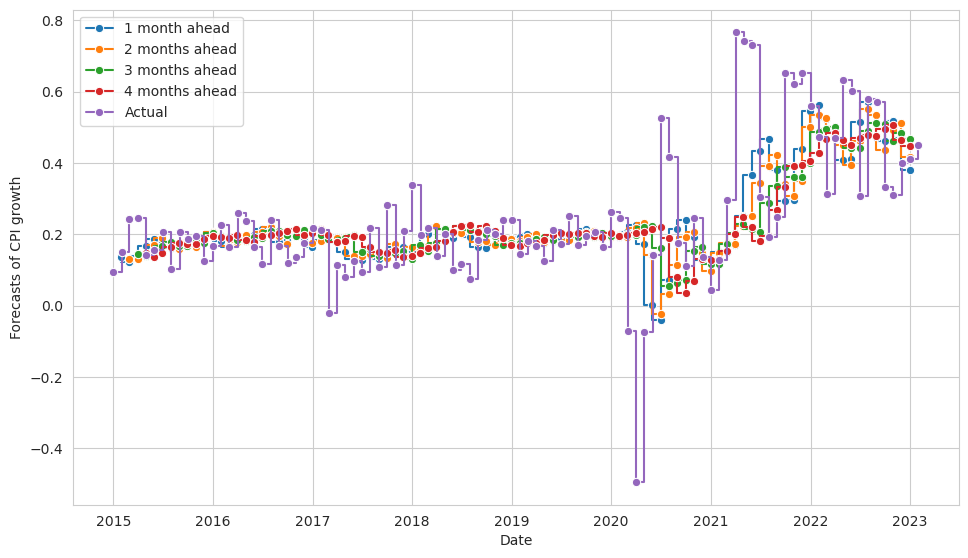

In [211]:
fig, ax = plt.subplots(figsize = (16/1.4, 9/1.4))
sns.lineplot(x = forecast_ses.index, y = forecast_ses["pred_1"].shift(1), label = "1 month ahead", drawstyle = "steps-pre", marker = 'o')
sns.lineplot(x = forecast_ses.index, y = forecast_ses["pred_2"].shift(2), label = "2 months ahead", drawstyle = "steps-pre", marker = 'o')
sns.lineplot(x = forecast_ses.index, y = forecast_ses["pred_3"].shift(3), label = "3 months ahead", drawstyle = "steps-pre", marker = 'o')
sns.lineplot(x = forecast_ses.index, y = forecast_ses["pred_4"].shift(4), label = "4 months ahead", drawstyle = "steps-pre", marker = "o")
sns.lineplot(data = df.query("DATE >= '2015-01-01'"), x = df.query("DATE >= '2015-01-01'").index, y = "CPI_growth", label = "Actual", drawstyle = "steps-post", marker = 'o')
plt.legend()
plt.ylabel("Forecasts of CPI growth")
plt.xlabel("Date")
fig.savefig("../out/q12_ar9_forecasts.png", dpi = 300)

In [206]:
do_forecasts_arma(9, 0).describe().apply(lambda s: s.apply(lambda x: np.round(x, 3))).T["mean"]

MSE_1     0.022
MSE_2     0.026
MSE_3     0.027
MSE_4     0.026
MSPE_1    1.461
MSPE_2    1.523
MSPE_3    1.482
MSPE_4    1.484
MAE_1     0.094
MAE_2     0.102
MAE_3     0.102
MAE_4     0.102
pred_1    0.233
pred_2    0.234
pred_3    0.233
pred_4    0.233
Name: mean, dtype: float64

In [207]:
do_forecasts_arma(1, 0).describe().apply(lambda s: s.apply(lambda x: np.round(x, 3))).T["mean"]

MSE_1     0.019
MSE_2     0.031
MSE_3     0.037
MSE_4     0.037
MSPE_1    2.243
MSPE_2    2.953
MSPE_3    3.199
MSPE_4    3.440
MAE_1     0.096
MAE_2     0.127
MAE_3     0.140
MAE_4     0.145
pred_1    0.259
pred_2    0.273
pred_3    0.281
pred_4    0.287
Name: mean, dtype: float64